<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Text classification with CNNs<a id="top"></a>

<i><small>Author: Alberto Díaz Álvarez<br>Last update: 2023-05-25</small></i></div>

***

## Introduction

In natural language processing (NLP), a very typical task is text classification. In this task, a given text is classified according to its meaning. It is often used, for example, for the problem of sentiment analysis.

This is a so-called _many-to-one_ problem, i.e., one where the input sequence size is $T_X = 1$, but the output sequence size is $T_Y = 1$.

## Goals

Let's do an exercise in which we will use the amazon reviews dataset for sentiment analysis. From the reviews and ratings data, we will identify whether a review is positive, neutral or negative. For this we will use a first approach using a Convolutional Neural Network (CNN) model network model.

## Libraries and configuration

Next we will import the libraries that will be used throughout the notebook.

In [1]:
import os.path
import requests
from shutil import unpack_archive

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

2023-05-25 18:25:27.677882: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


We will also configure some parameters to adapt the graphic presentation.

In [2]:
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

And create the necessary directories in case they have not been created previously

In [3]:
os.makedirs('tmp', exist_ok=True)

***

## Common parameters

We will start by defining the parameters that we will use throughout the notebook, which will consist of the maximum length of the sequences (remember that they must have a fixed length) and the dimension of the vector of each word.

In [4]:
# How many dimensions our word vectors have (50, 100, 200 or 300)
EMBEDDING_DIM = 300
# Our vocabulary max. size (the most frequent ones will be chosen)
MAX_VOCAB_SIZE = 16384
# Maximum sentence length
MAX_SEQUENCE_LEN = 32

## Dataset processing

We are going to load the training data, which will consist of the Amazon review data from the "Digital Music" category (https://nijianmo.github.io/amazon/index.html).

In [5]:
DATASET_URL = 'https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Digital_Music_5.json.gz'
DATASET_ZIP = 'tmp/Digital_Music_5.json.gz'

# Download the remote file if it does not exist
if not os.path.exists(DATASET_ZIP):
    with open(DATASET_ZIP, 'wb') as f:
        print(f'Downloading {DATASET_ZIP}...')
        r = requests.get(DATASET_URL, verify=False)
        f.write(r.content)
        print('OK')

corpus = pd.read_json(DATASET_ZIP, lines=True)
corpus.dropna(subset=['overall', 'reviewText'], inplace=True)
corpus.head()

overall  vote  verified   reviewTime      reviewerID        asin  \
0        5   3.0      True   06 3, 2013  A2TYZ821XXK2YZ  3426958910   
1        5   NaN      True  10 11, 2014  A3OFSREZADFUDY  3426958910   
2        5   NaN      True  02 11, 2014  A2VAMODP8M77NG  3426958910   
3        4   3.0     False   12 7, 2013   AAKSLZ9IDTEH0  3426958910   
4        5   NaN      True  06 12, 2016  A3OH43OZJLKI09  5557706259   

                      style       reviewerName  \
0  {'Format:': ' Audio CD'}            Garrett   
1  {'Format:': ' Audio CD'}                 Ad   
2  {'Format:': ' Audio CD'}             JTGabq   
3  {'Format:': ' Audio CD'}  john F&#039;n doe   
4  {'Format:': ' Audio CD'}  melinda a goodman   

                                          reviewText  \
0  This is awesome to listen to, A must-have for ...   
1                                               bien   
2  It was great to hear the old stuff again and I...   
3  well best of's are a bit poison normally but t...   
4  What can I say? This is Casting Crowns!!!This ...   

                                             summary  unixReviewTime image  
0                                      Slayer Rules!      1370217600   NaN  
1                                         Five Stars      1412985600   NaN  
2                        SLAYER!!!!!!!!!!!!!!!!!!!!!      1392076800   NaN  
3  slayer greatest hits! you mean everything righ...      1386374400   NaN  
4                    This is a good, blessing filled      1465689600   NaN

The process we will perform in this notebook will be to see how to build a convolutional model to work with this type of data sets. Therefore we will not go into the detail of obtaining a test data set.

However, it should be noted that in a real problem it would be necessary to train with validation and contrast with a test set before putting our model into production.

### Preparing the dataset input

The input to our model will be the reviews as such. Therefore, we will take the `reviewText` column as our training set.

In [6]:
x_train = corpus['reviewText'].astype(str).str.strip()
print(f'Training input shape: {x_train.shape}')

Training input shape: (169623,)


We will now create a [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, which will be responsible for:

1. will convert a complete review into a sequence of integers (words), assigning each word a unique value.
2. Truncate or padding so that the sequences maintain a fixed length previously established (in our case `MAX_SEQUENCE_LEN`).

The vocabulary will be extracted from our input, taking the `MAX_VOCAB_SIZE` most common words. We have added `+ 2` to the length since there are two tokens preassigned: Padding (`''`) and words outside the vocabulary (`'[UNK]'`).

In [7]:
vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=MAX_VOCAB_SIZE + 2,
    output_sequence_length=MAX_SEQUENCE_LEN,
)
vectorize_layer.adapt(x_train.to_numpy())

print(f'Vocabulary length: {len(vectorize_layer.get_vocabulary())}')

2023-05-25 18:25:33.556974: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-05-25 18:25:33.589490: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:37:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-25 18:25:33.591575: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:86:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-25 18:25:33.591614: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-05-25 18:25:33.595726: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-05

Vocabulary length: 16386


### Preparing the dataset output

Based on the assumption that those reviews with high ratings will be positive and those with low ratings will be negative, we will keep only the review and the product rating from the dataset.

In particular, we will convert review ratings to 0 if they are bad (1 or 2 stars), 1 if they are mediocre (3 stars) and 2 if they are good (4 or more stars).

In [8]:
y_train = corpus['overall'].astype(int).replace({
    1: 0,
    2: 0,
    3: 1,
    4: 2,
    5: 2,
})
print(f'Training output shape: {y_train.shape}')

Training output shape: (169623,)


## Using pre-trained embeddings in our language model

We have already seen that when building a language model, one important aspect is the representation of words. In order to capture the semantic meaning of words, we use word embeddings, which are dense vector representations of words in a high-dimensional space.

This time, rather than training our own word embeddings from scratch, we can take advantage of pre-trained embeddings, which have been trained on large corpora of text data. One popular pre-trained embedding is the Global Vectors for Word Representation (GLoVe), which was trained on a dataset of over 6 billion tokens. It has several pre-trained word vectors, so we will make use of those provided at http://nlp.stanford.edu/data/glove.6B.zip.

In [9]:
GLOVE_URL = 'http://nlp.stanford.edu/data/glove.6B.zip'
GLOVE_FILE = 'tmp/glove.6B.zip'

# Download the compressed GloVe dataset (if you don't already have it)
if not os.path.exists(GLOVE_FILE):
    print('Downloading ...', end='')
    with open(GLOVE_FILE, 'wb') as f:
        r = requests.get(GLOVE_URL, allow_redirects=True)
        f.write(r.content)
    print('OK')

# Unzip it in the directory 'glove'.
print('Unpacking ...', end='')
unpack_archive(GLOVE_FILE, 'tmp')
print('OK')

Unpacking ...OK


By using pre-trained embeddings like GLoVe, we can take advantage of the vast amount of knowledge encoded in these embeddings, which can improve the performance of our language model.

Now let's load the embedding of the dimension specified in the configuration. The file is composed of lines of tuples, where the first element is the word (in text) and the second is that word vector

In [10]:
print(f'Loading GloVe {EMBEDDING_DIM}-d embedding... ', end='')
word2vec = {}
with open(f'tmp/glove.6B.{EMBEDDING_DIM}d.txt') as f:
    for line in f:
        word, vector = line.split(maxsplit=1)
        word2vec[word] = np.fromstring(vector,'f', sep=' ')
print(f'done ({len(word2vec)} word vectors loaded)')

Loading GloVe 300-d embedding... 

400000 words are a lot of words. Since our vocabulary is smaller, we are going to create a smaller embedding layer, the size of our vocabulary. For it, we will include in this one only the vectors of the words that the `TextVectorization` layer will return us.

We will begin by creating the embedding matrix with the glove vectors

In [ ]:
print('Creating embedding matrix with GloVe vectors... ', end='')

# Our newly created embedding: a matrix of zeros
embedding_matrix = np.zeros((MAX_VOCAB_SIZE + 2, EMBEDDING_DIM))

ko_words = 0
for i, word in enumerate(vectorize_layer.get_vocabulary()):
    if word == '[UNK]':
        # The second word is for an unknown token, in glove is 'unk'
        word = 'unk'

    # Get the word vector and overwrite the row in its corresponding position
    word_vector = word2vec.get(word)
    if word_vector is not None:
        embedding_matrix[i] = word_vector
    else:
        ko_words += 1

print(f'done ({ko_words} words unassigned)')

Creating embedding matrix with GloVe vectors... done (3425 words unassigned)


Well, apparently there are a lot of words that have no correspondence in the downloaded embedding. It seems that 400000 tokens are not so many tokens.

Once this is done, we can create an embedding layer with the preloaded weight matrix.

In [ ]:
embedding_layer = tf.keras.layers.Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_matrix.shape[1],
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LEN,
    trainable=False,
    name='Embedding',
)

## Classification model based on convolutional neural networks (CNNs)

We will make a first approximation to the problem using convolutional networks. In this case, our sentences will be represented by single-row "images", with as many columns as the length of the specified sequence and as many channels as the dimension of each valabra of the sequence.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,  # [[1, 2, 3, 4, 5], [6, 7, 8, 9, 0]]
    embedding_layer,
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='sigmoid')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['sparse_categorical_accuracy'],
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, 32)                0         
_________________________________________________________________
Embedding (Embedding)        (None, 32, 300)           4915800   
_________________________________________________________________
conv1d (Conv1D)              (None, 30, 32)            28832     
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 32)            128       
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 2883      
Total params: 4,947,643
Trainable params: 31,779
Non-trainable params: 4,915,864
_________________________________________

Let's train the model and hope for the best.

In [ ]:
history = model.fit(x_train, y_train, epochs=50)

2023-05-25 17:54:49.495306: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-05-25 17:54:49.514546: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1900000000 Hz


Epoch 1/5
5305/5305 [==============================] - 24s 4ms/step - loss: 0.1713 - sparse_categorical_accuracy: 0.9539
Epoch 2/5
5305/5305 [==============================] - 22s 4ms/step - loss: 0.1424 - sparse_categorical_accuracy: 0.9593
Epoch 3/5
5305/5305 [==============================] - 22s 4ms/step - loss: 0.1304 - sparse_categorical_accuracy: 0.9616
Epoch 4/5
5305/5305 [==============================] - 22s 4ms/step - loss: 0.1210 - sparse_categorical_accuracy: 0.9638
Epoch 5/5
5305/5305 [==============================] - 22s 4ms/step - loss: 0.1137 - sparse_categorical_accuracy: 0.9653


Let's take a look at the training progress:

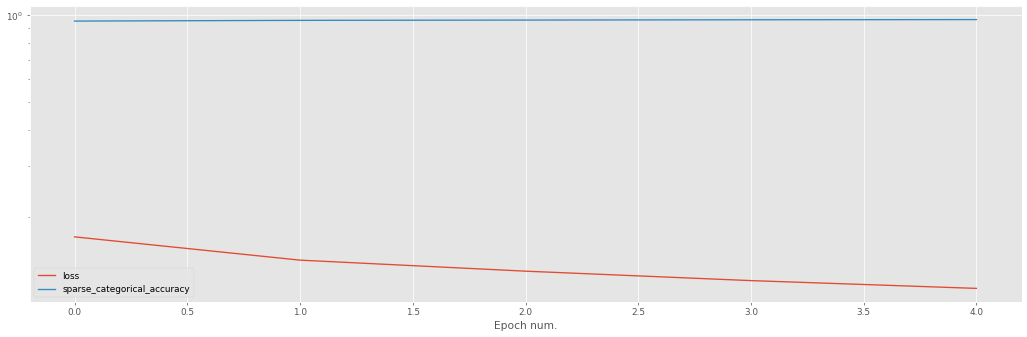

In [ ]:
pd.DataFrame(history.history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.show()

Now let's see how it interprets the sentiment of a good, fair and bad review extracted from the amazon website.

In [ ]:
good = "My nephew is on the autism spectrum and likes to fidget with things so I knew this toy would be a hit. Was concerned that it may not be \"complex\" enough for his very advanced brain but he really took to it. Both him (14 yrs) and his little brother (8 yrs) both enjoyed playing with it throughout Christmas morning. I'm always happy when I can find them something unique and engaging."
poor = "I wasn't sure about this as it's really small. I bought it for my 9 year old grandson. I was ready to send it back but my daughter decided it was a good gift so I'm hoping he likes it. Seems expensive for the price though to me."
evil = "I just wanted to follow up to say that I reported this directly to the company and had no response. I have not gotten any response from my review. The level of customer service goes a long way when an item you purchase is defective and this company didn’t care to respond. No I am even more Leary about ordering anything from this company. I never asked for a refund or replacement since I am not able to return it. I’m just wanted to let them know that this was a high dollar item and I expected it to be a quality item. Very disappointed! I bought this for my grandson for Christmas. He loved it and played with it a lot. My daughter called to say that the stickers were peeling on the corners. I am not able to take it from my grandson because he is autistic and wouldn’t understand. I just wanted to warn others who are wanting to get this. Please know that this is a cool toy and it may not happen to yours so it is up to you."

probabilities = model.predict([good, poor, evil], verbose=0)
print(f'Good was classified as {np.argmax(probabilities[0])}')
print(f'Poor was classified as {np.argmax(probabilities[1])}')
print(f'Evil was classified as {np.argmax(probabilities[2])}')

Good was classified as 2
Poor was classified as 2
Evil was classified as 1


## Conclusions

We have demonstrated how to use a convolutional neural network (CNN) to classify text, specifically, product reviews as good, average or bad. We also discussed the benefits of using pre-trained word embeddings, which can help improve the performance of the model by leveraging the semantic relationships between words in the pre-trained corpus. We also explored the TextVectorization layer, which provides a flexible way to preprocess text data and convert it into numerical vectors.

This is an example that can serve as a starting point for a multitude of NLP projects.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Back to top](#top)

</div>